<a href="https://colab.research.google.com/github/VinayakMaharaj/STA365-Final-Project/blob/main/Proj_test_code_JM_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pymc as pm
import arviz as az
from pymc.math import invlogit as tt_invlogit


from google.colab import files
uploaded = files.upload() #this will prompt you to choose a file
import io
df = pd.read_csv(io.BytesIO(uploaded['players_are_filtered.csv']))

Saving players_are_filtered.csv to players_are_filtered.csv


In [2]:
print(df.head(n=5))

   Unnamed: 0.1  Unnamed: 0   GAME_ID LOCATION  SHOT_NUMBER  PERIOD  \
0             0           0  21400899        A            1       1   
1             1           1  21400899        A            2       1   
2             2           2  21400899        A            3       1   
3             3           3  21400899        A            4       2   
4             4           4  21400899        A            5       2   

   GAME_HALF GAME_CLOCK  GAME_CLOCK_DECIMAL  SHOT_CLOCK  ...  player_id  \
0          1       1:09            1.150000        10.8  ...     203148   
1          1       0:14            0.233333         3.4  ...     203148   
2          1       0:00            0.000000         NaN  ...     203148   
3          1      11:47           11.783333        10.3  ...     203148   
4          1      10:34           10.566667        10.9  ...     203148   

   PLAYER_HEIGHT  PLAYER_WEIGHT EXCLUDE SEASON_SHOTS_TAKEN  GAME_SHOTS_TAKEN  \
0         185.42      78.471416       0   

In [3]:
#need to remove some variables we dont need for the analysis
df2 = df.iloc[:, 2:]

df3 = df2.drop(columns= ["GAME_ID", "GAME_CLOCK","SHOT_STREAK", "GAME_HALF",
                           "player_name", "player_id", "GAME_SHOTS_TAKEN",
                           "SHOT_RESULT", "REFORMATED_DEF_NAME",
                           "CLOSEST_DEFENDER_PLAYER_ID", "SEASON_SHOTS_TAKEN" ])

#remove any rows that have some kind of error
df3 = df3[df3.EXCLUDE == 0]

#no longer need exclude and fgm column
clean = df3.drop(columns= ["EXCLUDE"])

# replace 'A' with '0'
clean['LOCATION'].replace('A', 0, inplace=True)
# replace 'A' with '0'
clean['LOCATION'].replace('H', 1, inplace=True)
# when shot clock is NaN, we will replace shot clock with game clock value
clean.loc[df['SHOT_CLOCK'].isnull(),'SHOT_CLOCK'] = df['GAME_CLOCK_DECIMAL']

print(clean.head(n=5))

   LOCATION  SHOT_NUMBER  PERIOD  GAME_CLOCK_DECIMAL  SHOT_CLOCK  DRIBBLES  \
0         0            1       1            1.150000        10.8         2   
1         0            2       1            0.233333         3.4         0   
2         0            3       1            0.000000         0.0         3   
3         0            4       2           11.783333        10.3         2   
4         0            5       2           10.566667        10.9         2   

   SHOT_DIST  PTS_TYPE  DEFENDER_HEIGHT_CM  DEFENDER_WEIGHT_KG  \
0        7.7         2              198.12           99.790240   
1       28.2         3              203.20           97.975872   
2       10.1         2              203.20           97.975872   
3       17.2         2              190.50           86.182480   
4        3.7         2              203.20          100.243832   

   CLOSE_DEF_DIST  FGM  PLAYER_HEIGHT  PLAYER_WEIGHT  HOT_HAND_SHOT_STREAK2  \
0             1.3    1         185.42      78.471416   

In [4]:
len(clean)

123905

In [5]:
np.random.seed(23)
N = 500 #number of samples to make code run faster
samp = clean.sample(N, replace=False)

# will divide the sample dataset into 2 subdatasets
base = samp[(samp.HOT_HAND_SHOT_STREAK3 ==0) & (samp.FGM == 1)]
hot = samp[(samp.HOT_HAND_SHOT_STREAK3 ==1) & (samp.FGM == 1)]

# number of "hot hand shots taken"
print(sum(samp['HOT_HAND_SHOT_STREAK2']), 'and', sum(samp['HOT_HAND_SHOT_STREAK3']))



55 and 16


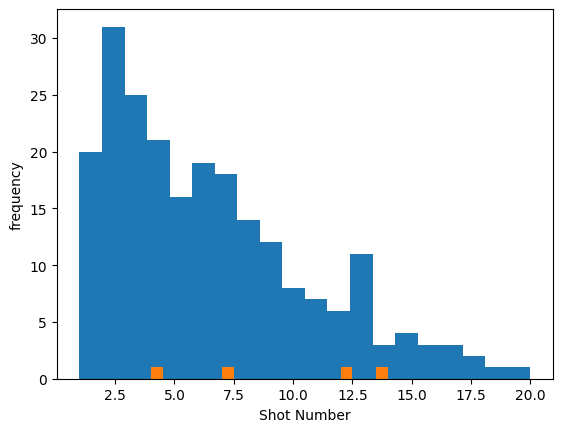

In [6]:
# Exploratory Data Analysis
plt.hist(base['SHOT_NUMBER'],bins=20)
plt.hist(hot['SHOT_NUMBER'],bins=20)
plt.xlabel('Shot Number')
plt.ylabel('frequency')
plt.show()

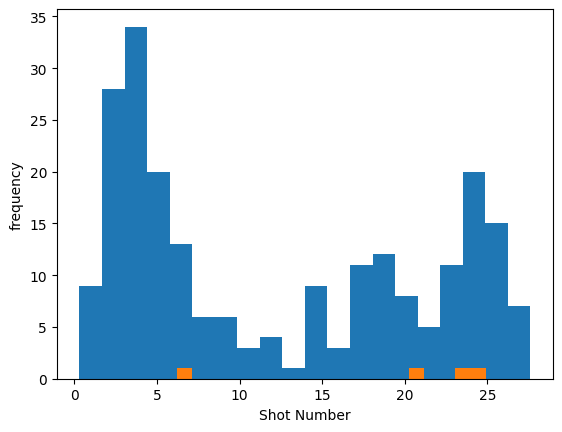

In [7]:
# Exploratory Data Analysis
plt.hist(base['SHOT_DIST'],bins=20)
plt.hist(hot['SHOT_DIST'],bins=20)
plt.xlabel('Shot Number')
plt.ylabel('frequency')
plt.show()

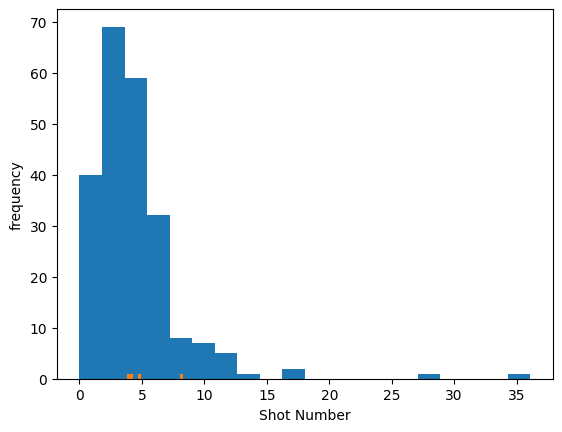

In [8]:
# Exploratory Data Analysis
plt.hist(base['CLOSE_DEF_DIST'],bins=20)
plt.hist(hot['CLOSE_DEF_DIST'],bins=20)
plt.xlabel('Shot Number')
plt.ylabel('frequency')
plt.show()

In [9]:
samp.describe()

,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK_DECIMAL,SHOT_CLOCK,DRIBBLES,SHOT_DIST,PTS_TYPE,DEFENDER_HEIGHT_CM,DEFENDER_WEIGHT_KG,CLOSE_DEF_DIST,FGM,PLAYER_HEIGHT,PLAYER_WEIGHT,HOT_HAND_SHOT_STREAK2,HOT_HAND_SHOT_STREAK3,GAME_TIME_ELAPSED
count,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.510000,6.56200,2.488000,5.790833,12.410200,2.144000,14.22420,2.298000,201.289920,101.992883,4.278800,0.458000,200.218040,100.199380,0.110000,0.032000,24.009167
std,0.500401,4.64902,1.161272,3.298306,6.080914,3.861228,9.13682,0.457838,9.183651,11.861156,3.311598,0.498732,8.770753,11.726640,0.313203,0.176176,14.010581
min,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.30000,2.000000,175.260000,76.203456,0.000000,0.000000,175.260000,73.028312,0.000000,0.000000,0.216667
25%,0.000000,3.00000,1.000000,3.154167,7.900000,0.000000,4.80000,2.000000,195.580000,92.986360,2.200000,0.000000,193.040000,90.718400,0.000000,0.000000,11.120833
50%,1.000000,5.50000,3.000000,5.841667,12.400000,0.000000,16.05000,2.000000,203.200000,102.058200,3.800000,0.000000,200.660000,99.790240,0.000000,0.000000,24.316667
75%,1.000000,9.00000,4.000000,8.600000,16.900000,3.000000,23.00000,3.000000,208.280000,111.130040,5.400000,1.000000,208.280000,108.862080,0.000000,0.000000,36.345833
max,1.000000,30.00000,6.000000,11.800000,24.000000,25.000000,44.80000,3.000000,218.440000,133.809640,36.100000,1.000000,215.900000,131.088088,1.000000,1.000000,55.250000


In [10]:
#number of predictors
P = 13

#predictors
x1 = samp['LOCATION']
x2 = samp['SHOT_NUMBER']
x3 = samp['PERIOD']
x4 = samp['GAME_CLOCK_DECIMAL']
x5 = samp['SHOT_CLOCK']
x6 = samp['DRIBBLES']
x7 = samp['SHOT_DIST']
x8 = samp['DEFENDER_HEIGHT_CM']
x9 = samp['DEFENDER_WEIGHT_KG']
x10 = samp['CLOSE_DEF_DIST']
x11 = samp['PLAYER_HEIGHT']
x12 = samp['PLAYER_WEIGHT']
x13 = samp['HOT_HAND_SHOT_STREAK3']


num_obs = len(x1)
intercept = np.ones((num_obs,1))
X = np.zeros((len(x1),P+1))
# standardize the predictor values
X[:, 0] = intercept.reshape(-1)
X[:,1] = (x1-np.mean(x1))/np.std(x1)
X[:,2] = (x2-np.mean(x2))/np.std(x2)
X[:,3] = (x3-np.mean(x3))/np.std(x3)
X[:,4] = (x4-np.mean(x4))/np.std(x4)
X[:,5] = (x5-np.mean(x5))/np.std(x5)
X[:,6] = (x6-np.mean(x6))/np.std(x6)
X[:,7] = (x7-np.mean(x7))/np.std(x7)
X[:,8] = (x8-np.mean(x8))/np.std(x8)
X[:,9] = (x9-np.mean(x9))/np.std(x9)
X[:,10] = (x10-np.mean(x10))/np.std(x10)
X[:,11] = (x11-np.mean(x11))/np.std(x11)
X[:,12] = (x12-np.mean(x12))/np.std(x12)
X[:,13] = (x13-np.mean(x13))/np.std(x13)

print(X)

[[ 1.          0.98019606  2.24745316 ...  0.9201073   1.16537091
  -0.18181818]
 [ 1.          0.98019606 -0.55163585 ...  0.63021842 -0.2285208
  -0.18181818]
 [ 1.          0.98019606 -0.55163585 ...  0.9201073   1.04921327
  -0.18181818]
 ...
 [ 1.          0.98019606  0.09430777 ...  0.63021842  0.54586348
  -0.18181818]
 [ 1.         -1.02020406  0.30962231 ... -0.23944821 -0.34467845
  -0.18181818]
 [ 1.          0.98019606 -0.98226493 ...  0.05044067 -0.46083609
  -0.18181818]]


In [11]:
y2 = np.zeros((num_obs,1))
y2[:,0] = samp['FGM']

In [30]:
#SECOND MODEL

#number of predictors
P = 9

#predictors
x1 = samp['LOCATION']
x2 = samp['SHOT_CLOCK']
x3 = samp['SHOT_DIST']
x4 = samp['DEFENDER_HEIGHT_CM']
x5 = samp['DEFENDER_WEIGHT_KG']
x6 = samp['CLOSE_DEF_DIST']
x7 = samp['PLAYER_HEIGHT']
x8 = samp['PLAYER_WEIGHT']
x9 = samp['HOT_HAND_SHOT_STREAK3']


num_obs = len(x1)
intercept = np.ones((num_obs,1))
X = np.zeros((len(x1),P+1))
# standardize the predictor values
X[:, 0] = intercept.reshape(-1)
X[:,1] = (x1-np.mean(x1))/np.std(x1)
X[:,2] = (x2-np.mean(x2))/np.std(x2)
X[:,3] = (x3-np.mean(x3))/np.std(x3)
X[:,4] = (x4-np.mean(x4))/np.std(x4)
X[:,5] = (x5-np.mean(x5))/np.std(x5)
X[:,6] = (x6-np.mean(x6))/np.std(x6)
X[:,7] = (x7-np.mean(x7))/np.std(x7)
X[:,8] = (x8-np.mean(x8))/np.std(x8)
X[:,9] = (x9-np.mean(x9))/np.std(x9)


print(X)

[[ 1.          0.98019606 -0.42967459 ...  0.9201073   1.16537091
  -0.18181818]
 [ 1.          0.98019606  1.2987689  ...  0.63021842 -0.2285208
  -0.18181818]
 [ 1.          0.98019606  0.57446877 ...  0.9201073   1.04921327
  -0.18181818]
 ...
 [ 1.          0.98019606 -0.93997695 ...  0.63021842  0.54586348
  -0.18181818]
 [ 1.         -1.02020406 -0.21567682 ... -0.23944821 -0.34467845
  -0.18181818]
 [ 1.          0.98019606  1.85845536 ...  0.05044067 -0.46083609
  -0.18181818]]


In [16]:
import pymc as pm; import numpy as np
#model 1
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu= np.zeros((P+1,1)), cov=np.eye(P+1), shape=(P+1,1))
    y = pm.Bernoulli('y', logit_p = pm.math.dot(X, betas), observed = y2)
with MLR:
    idata = pm.sample()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


HMC Split-Rhats {'betas': array([[1.00038847, 0.99967127, 1.00110855, 1.00227639, 0.99974772,
        1.00212693, 1.00279822, 1.00607874, 1.0002209 , 1.00199114],
       [1.00036089, 1.00103727, 1.00073925, 1.0016249 , 1.00144743,
        0.99944421, 1.0012548 , 1.00644216, 0.99939727, 1.00025946],
       [0.99943947, 1.00046574, 1.00272942, 1.0002206 , 0.99983337,
        1.00153412, 1.00300867, 1.00016014, 1.00191446, 1.00042014],
       [1.00005522, 1.00070531, 1.00175935, 0.99986561, 0.99955012,
        0.9996863 , 1.00037058, 1.00136331, 1.00025217, 0.99989174],
       [1.00291795, 0.99960622, 0.99926344, 1.00008207, 1.00046702,
        1.00011913, 0.99962678, 0.99965236, 1.00127965, 1.00006744],
       [0.99949128, 1.00086678, 1.00057775, 1.00036593, 1.00029338,
        1.00031189, 0.99984961, 1.00133592, 1.00130131, 0.99970447],
       [0.99919503, 1.00012491, 1.00089523, 1.00087079, 0.9995157 ,
        0.99971652, 1.0016331 , 0.99941574, 1.00185023, 1.00073358],
       [1.00283

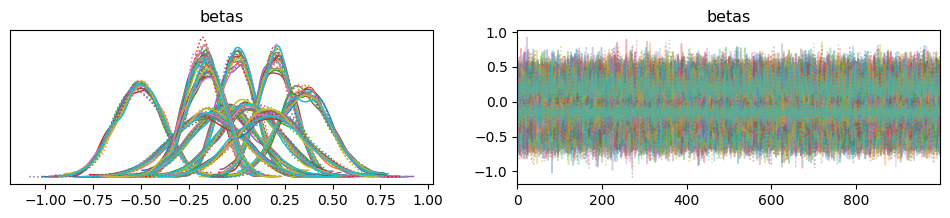

In [17]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata);
print("HMC Split-Rhats", {k: np.round(v.values,P+1) for k,v in az.rhat(idata).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.

In [26]:
import pymc as pm; import numpy as np
from pymc.math import invlogit as tt_invlogit
#model 2
with pm.Model() as MLR:
    #LKJ cov
    packed_L = pm.LKJCholeskyCov("packed_L", n= P+1, eta=2.0, sd_dist=pm.HalfCauchy.dist(beta=10, shape=P+1), compute_corr=False)
    L = pm.expand_packed_triangular(P+1, packed_L);
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    #Horsehoe prior to help distinguish useful predictors
    tau_0 = 0.03;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(P+1));
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P+1))
    betas = pm.MvNormal('betas', mu= np.zeros((P+1,1)), cov= Sigma, shape=(P+1))

    y = pm.Bernoulli('y', logit_p = pm.math.dot(X, betas*weights), observed = y2)
with MLR:
    idata = pm.sample()

    #for proj we can make note on how long it takes computationally to use chol

/usr/local/lib/python3.10/dist-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


ValueError: Not enough samples to build a trace.

In [28]:
import pymc as pm; import numpy as np
from pymc.math import invlogit as tt_invlogit

#model 3
with pm.Model() as MLR:

    #Horsehoe prior to help distinguish useful predictors
    tau_0 = 1;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(P+1));
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P+1))
    betas = pm.MvNormal('betas', mu= np.zeros((P+1,1)), cov= np.eye(P+1), shape=(P+1))

    y = pm.Bernoulli('y', logit_p = pm.math.dot(X, betas*weights), observed = y2)
with MLR:
    idata = pm.sample()

HMC Split-Rhats {'weights': array([1.00564599, 1.00310008, 1.832857  , 1.4945512 , 1.83891404,
       1.00393462, 1.00179981, 1.83108228, 1.33508403, 1.83148781]), 'betas': array([[1.00410213, 1.00193375, 1.78266338, 1.44175647, 1.75233915,
        1.00128817, 1.0011652 , 1.76311633, 1.2859265 , 1.71345365],
       [1.00077254, 1.0014334 , 1.00340477, 1.00193138, 1.00853985,
        1.0021412 , 1.00109321, 1.00283486, 1.00234043, 1.00635447],
       [1.0018028 , 1.00031528, 1.82146448, 1.48935059, 1.82216279,
        1.00237683, 1.00339708, 1.81765938, 1.30937641, 1.81681306],
       [1.00141721, 1.00097351, 1.83042768, 1.49048079, 1.8289075 ,
        1.00239497, 1.00112997, 1.82724609, 1.26711519, 1.8284886 ],
       [1.0018526 , 0.99985409, 1.00120725, 1.00426179, 1.00254279,
        1.00081367, 1.00006555, 1.00047497, 0.99928288, 1.00099609],
       [1.00270701, 1.00066242, 1.04981992, 1.03314593, 1.05629101,
        1.00063453, 1.00382736, 1.05845777, 1.02962311, 1.04142373],
     

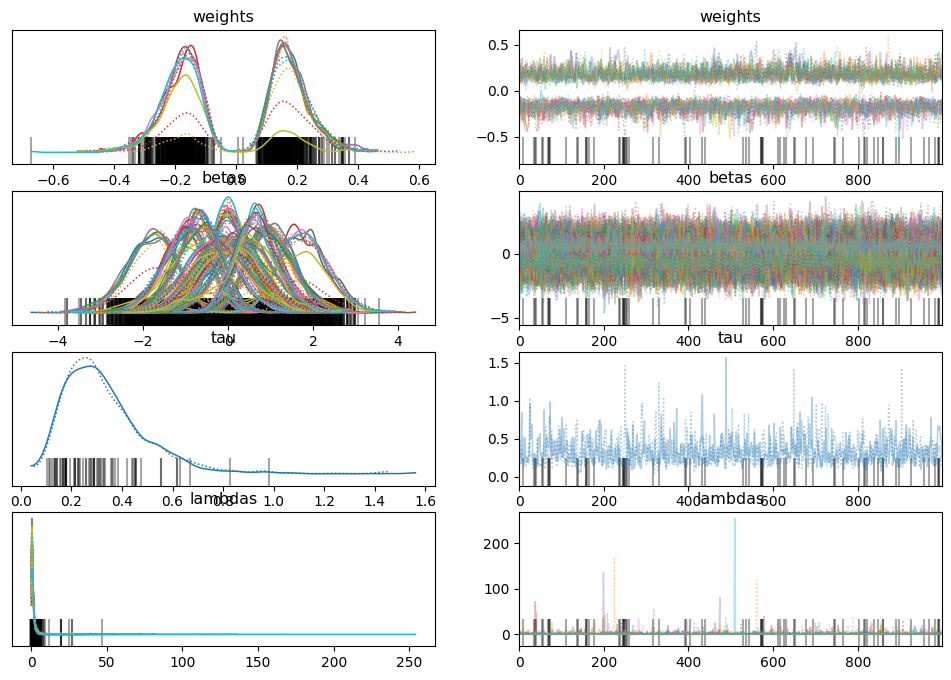

In [29]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata);
print("HMC Split-Rhats", {k: np.round(v.values,P+1) for k,v in az.rhat(idata).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.

TypeError: 'Axes' object is not subscriptable

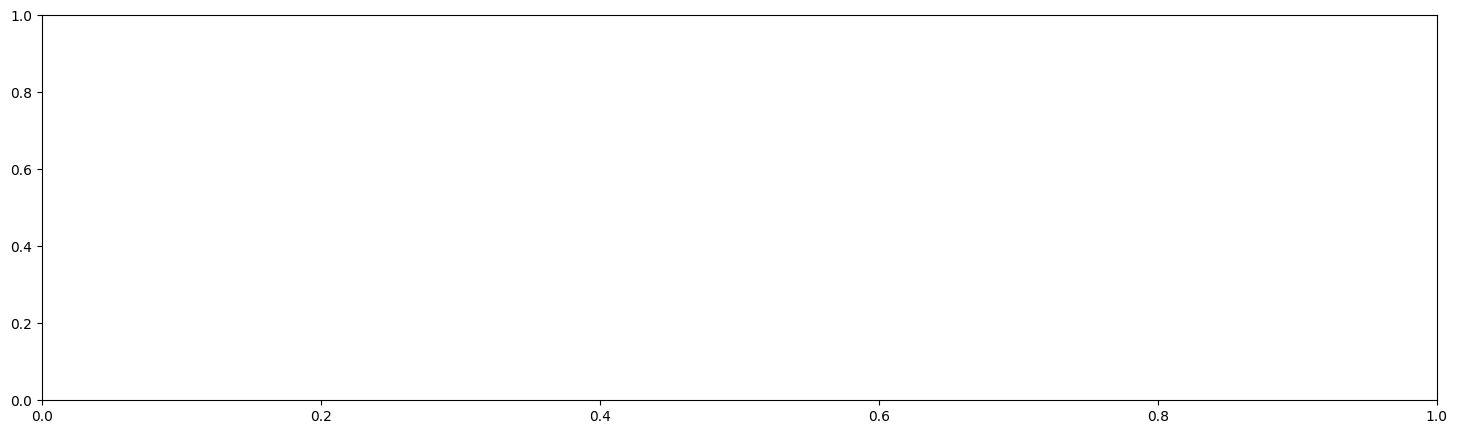

In [47]:
fix,ax = plt.subplots(1,1,figsize=(18,5));
par_1p0 = np.array(2*[np.arange(len(idata.posterior['weights'].values[0].mean(axis=0)))]);
val_1p0 = np.percentile(idata.posterior['weights'].values[0], [1, 99], axis=0);
ax[0].plot(par_1p0, val_1p0,'orange');
ax[0].plot(par_1p0[:,0],val_1p0[:,0],'orange', label='98% credible');
ax[0].set_ylabel('$\\tau_0$=1');
ax[0].legend();